In [1]:
%matplotlib inline
import pandas as pd
import pdb
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from pathlib import Path
from collections import Counter
from util import *

# Load data

In [2]:
home = str(Path.home())
DATA_DIR = f'{home}/Downloads/hpca22_supercloud'
anon_dcgm_df = pd.read_csv(f'{DATA_DIR}/dcgm.csv')
user_df = pd.read_csv(f'{DATA_DIR}/scheduler_data.csv')

In [3]:
gpu_avg_df=anon_dcgm_df.groupby('id_job').mean()
#Add GPU count info and "node list"in gpu_avg_df
hash_gpu_count=Counter(anon_dcgm_df['id_job']) #rename hash_gpu_count
gpu_avg_df['GPU_Count']=0
for job in gpu_avg_df.index:
    gpu_avg_df.loc[job,'GPU_Count']=hash_gpu_count[job]
gpu_avg_df['GPU_Range']=0
for job in gpu_avg_df[gpu_avg_df['GPU_Count']==1].index:
    gpu_avg_df.loc[job,'GPU_Range']='1 GPU'
df1=gpu_avg_df[gpu_avg_df['GPU_Count']==2]
for job in df1.index:
    gpu_avg_df.loc[job,'GPU_Range']='2 GPU'
df1=gpu_avg_df[gpu_avg_df['GPU_Count']>2]
df5_8=df1[df1['GPU_Count']<9]
for job in df5_8.index:
    gpu_avg_df.loc[job,'GPU_Range']='3-8 GPU'
df1=gpu_avg_df[gpu_avg_df['GPU_Count']>8]
for job in df1.index:
    gpu_avg_df.loc[job,'GPU_Range']='>8 GPU'
grouped_node_df=anon_dcgm_df[['Node','id_job']].groupby('id_job').agg({'Node':lambda x: ' '.join(x)})
grouped_node_df.columns=['Node_List']
gpu_avg_df=gpu_avg_df.join(grouped_node_df,how='inner')
gpu_avg_df['Num_node']=gpu_avg_df['Node_List'].str.split(' ').apply(lambda x: len(set(x)))

# Generate empirical CDF of GPU utilizations

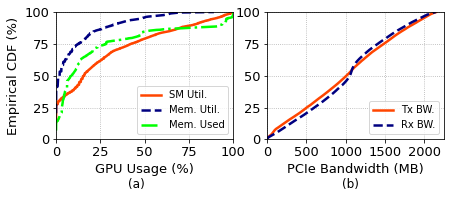

In [4]:
gpu_join = gpu_avg_df[gpu_avg_df.totalexecutiontime_sec>30]
plot_cdf_utilization(gpu_join)

# Merge scheduler data and node data

In [5]:
user_df['run_time_from_user_df']=user_df['time_end']-user_df['time_start']

#user_df has been renamed to user_df_no_dup. be careful of its usage later
if (user_df.shape[0]!=len(user_df['id_job'].unique())): #if there are duplicates
    tmp_df=user_df[user_df['id_job'].duplicated(keep=False)][['id_job', 'derived_ec', 'state']] #may need to rewrite for 2021-IAP. it doesnt have these columns
    idx_to_drop=tmp_df.index[tmp_df['state']!=3]
    user_df_no_dup=user_df.drop(idx_to_drop)
    assert (user_df_no_dup.shape[0]==len(user_df_no_dup['id_job'].unique())) #all unique now
else:
    user_df_no_dup=user_df

user_df_no_dup=user_df_no_dup.set_index('id_job')
gpu_user_join=gpu_avg_df.join(user_df_no_dup,how='inner')
gpu_user_join_rm_small_runtime=gpu_user_join[gpu_user_join.totalexecutiontime_sec>30]
gpu_user_join_rm_small_runtime['wait_time']=gpu_user_join_rm_small_runtime['time_start']-gpu_user_join_rm_small_runtime['time_submit']

/home/baolin/anaconda3/envs/sevir/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


# GPU Utilization of different types of jobs

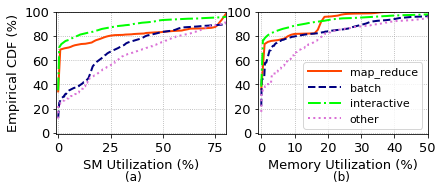

In [6]:
plot_cdf_types(gpu_user_join_rm_small_runtime)

# Bottleneck analysis

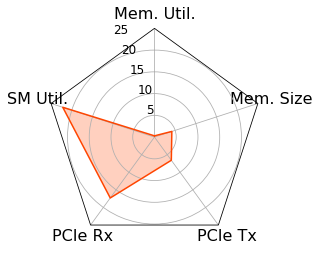

In [7]:
# import plot_functions
plot_bottlenecks(gpu_user_join_rm_small_runtime)

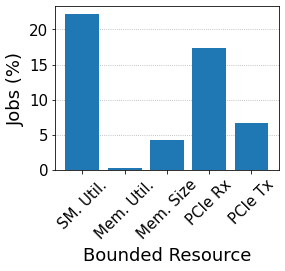

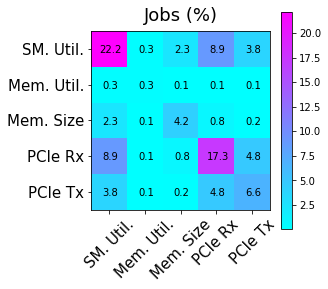

In [8]:
plot_res_bound(gpu_user_join_rm_small_runtime)

# Power capping

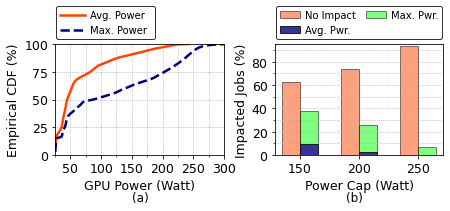

In [9]:
plot_power_cap(gpu_user_join_rm_small_runtime)

# Jobs submitted by the same user

/home/baolin/GIT/HPCA22_SuperCloud/util.py:302: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpu_user_join_rm_small_runtime['maxgpumemoryused_bytes_pct']=gpu_user_join_rm_small_runtime['maxgpumemoryused_bytes']/3.2e+10*100


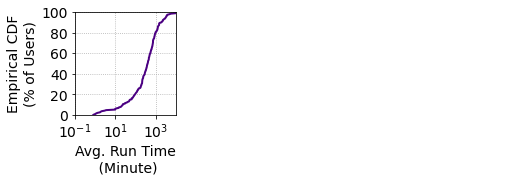

In [10]:
plot_jobs_by_same_user(gpu_user_join_rm_small_runtime)

# Multi-GPU jobs

GPU Count Range 	 Jobs 	 Percentage_of_jobs
1 GPU 	 39656 	 84.16
2 GPU 	 6368 	 13.51
3-8 GPU 	 779 	 1.65
>8 GPU 	 317 	 0.67


/home/baolin/GIT/HPCA22_SuperCloud/util.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpu_user_join_rm_small_runtime['GPU_hours']=gpu_user_join_rm_small_runtime.GPU_Count*gpu_user_join_rm_small_runtime.totalexecutiontime_sec


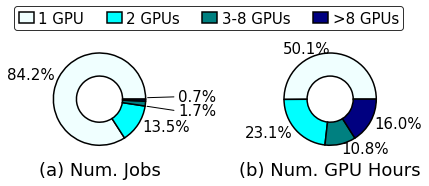

In [11]:
plot_multi_gpu_jobs(gpu_user_join_rm_small_runtime)

# Job types

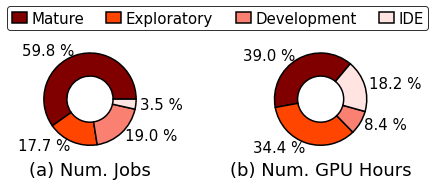

In [12]:
plot_job_types_pie()

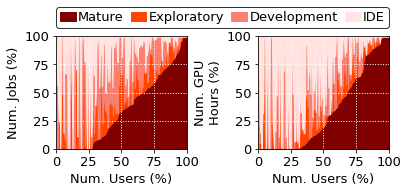

In [13]:
import warnings
warnings.filterwarnings('ignore')
plot_users_and_job_types(gpu_user_join, gpu_user_join_rm_small_runtime)